# Scaling ML using Cloud ML Engine

## Contents

1. Data Science Workflow
2. Where to develop?
3. Hands-ON Tutorial: Running MNIST on ML-Engine
   1. Setup
   2. Training Possibilities
   3. Evaluation 
   4. Deployment
4. Recap
5. Appendix
   1. Jupyter Slides

# 1. Data Science Workflow

- Goal is to standardise the development of models
     - Checklist of necessary technical steps

> Vision: Achieve an first end-to-end model in production within a *productincrement* of 10 weeks

> Scale out: Scale without having to rewrite your model

In [1]:
%%javascript // some javascript to render markdown tables properly

// from https://github.com/jupyter/notebook/issues/3024#issuecomment-435630413
var marked = require('components/marked/lib/marked');

if (marked.Renderer.name !== 'NonExtensibleTableRenderer') {
    function tablecell(content, flags) {
        var type = flags.header ? 'th' : 'td';
        var style = flags.align == null ? '' : ' style="text-align: ' + flags.align + '"';
        var start_tag = '<' + type + style + '>';
        var end_tag = '</' + type + '>\n';
        return start_tag + content + end_tag;
    }

    var DefaultRenderer = marked.Renderer;
    function NonExtensibleTableRenderer(options) {
        DefaultRenderer.call(this, options);
        Object.defineProperty(this, 'tablecell', {
            get: function () { return tablecell; },
            set: function () { } // No-op, sorry for this hack but we must prevent it from being redefined
        });
    }
    NonExtensibleTableRenderer.prototype = Object.create(DefaultRenderer.prototype);
    NonExtensibleTableRenderer.prototype.constructor = NonExtensibleTableRenderer;

    marked.setOptions({
        renderer: new NonExtensibleTableRenderer()
    });
    // Look away... it has to be done as newer versions of the notebook build a custom
    // renderer rather than extending the default.
    marked.Renderer = NonExtensibleTableRenderer;
}

var Jupyter = require('base/js/namespace');
Jupyter.notebook.get_cells()
   .filter(cell => cell.cell_type === 'markdown' && cell.rendered)
   .forEach(mdcell => {
       mdcell.unrender();
       mdcell.render();
   });

<IPython.core.display.Javascript object>


### Data Science Process - Proposal

|   Step 1: Preparation       |      Step 2: Data exploration and model building                   |    Step 3: Model deployment                    
|   :-----      |      :----                 |   :----
| 1.1  Project setup          | 2.1  One click to start the Data Scientist Exploration Environment | 3.1  Model serving                             
| 1.2  Quick data exploration | 2.2  Setup for Data exploration and Machine Learning               | 3.2  Model deployment (load balancing ...)     
| 1.3  Data visualization     | 2.3  Deep dive in data exploration                                 | 3.3  Model versioning                           
|        -                    | 2.4  Data visualization and profiling                              | 3.4  Model monitoring                          
|        -                    | 2.5  Feature engineering                                           |                        -                       
|        -                    | 2.6  Model building                                                |                        -                       
|        -                    | 2.7  Model training                                                |                        -                       
|        -                    | 2.8  Model testing                                                 |                        -                       
|        -                    | 2.9  Hyparameters tuning                                           |                        -                       
|        -                    | 2.10 Model visualisation                                           |                        -                       
> steps 1 and 2 can be done *only* locally

We will look today at
    - 2.7 How to train a model?
    - 2.8 How to evaluate a model?
    - 3.1 How to make predictions?
    - 3.2 How to deploy a model?

Should help to answer:
- Where do we need to improve?
- Where to go next?

> Process description will be refined.

# 2. Where to develop?

|SDK on local Machine | Google Console |
|---------------------|----------------|
| your machine | Tiny Compute Engine with 5 GB storage |
| Your IDE | Code Editor|
| Jupyter Notebook | Datalab |
| `gcloud ml-engine local` | `gcloud ml-engine`


Locally using
- Google SDK on your laptop (CLI)
- your IDE (e.g. PyCharme)
- Juypter Notebook
- `gcloud ml-engine local` 

Simple Cloud setup using
- [Google Console](https://console.cloud.google.com/) Compute Engine with 5 GB storage
- Cloud Editor
- datalab
- `gcloud ml-engine` (`local`)

## Proposal

- when to migrate to GCP:
   - distribute learning on several machines
   - serve model 24/7


> develop locally


# 3. Hands-ON Tutorial: Running MNIST on ML-Engine

- deep dive into step 2 and 3 of Data Science process
- data exploration is omitted as a curated dataset is used

Adapted from [Notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/cloudmle/cloudmle.ipynb) of Google Coursera Course [Serverless Machine Learning with Tensorflow on Google Cloud Platform](https://www.coursera.org/learn/serverless-machine-learning-gcp/)

- In order to import from `src` functionality later in this notebook, it is necessary to change to the root directory of the notebooks directory

In [3]:
# check working directory
import os
WORKINGDIR = os.getcwd()
print("Current Working direcotory:\t{}".format(WORKINGDIR))
folders = os.path.split(WORKINGDIR)
if folders[-1] == 'notebook':  # or a list: in ['notebook', 'src', etc.]
  WORKINGDIR = folders[0] 
  print("Changed to New working directory:\t{}".format(WORKINGDIR))
  os.chdir(WORKINGDIR) 

Current Working direcotory:	c:\Users\kzl465\Documents\gcp_ml_engine_talk\notebook
Changed to New working directory:	c:\Users\kzl465\Documents\gcp_ml_engine_talk


In [1]:
conda info -e

# conda environments:
#
base                     C:\Users\kzl465\AppData\Local\Continuum\anaconda3
bioservices              C:\Users\kzl465\AppData\Local\Continuum\anaconda3\envs\bioservices
charite                  C:\Users\kzl465\AppData\Local\Continuum\anaconda3\envs\charite
dtd                      C:\Users\kzl465\AppData\Local\Continuum\anaconda3\envs\dtd
env_gcp_dl               C:\Users\kzl465\AppData\Local\Continuum\anaconda3\envs\env_gcp_dl
gcp_dl                *  C:\Users\kzl465\AppData\Local\Continuum\anaconda3\envs\gcp_dl
pytorch                  C:\Users\kzl465\AppData\Local\Continuum\anaconda3\envs\pytorch
rdkit-env                C:\Users\kzl465\AppData\Local\Continuum\anaconda3\envs\rdkit-env
tf2_gpu                  C:\Users\kzl465\AppData\Local\Continuum\anaconda3\envs\tf2_gpu
tf_gpu                   C:\Users\kzl465\AppData\Local\Continuum\anaconda3\envs\tf_gpu
vamb                     C:\Users\kzl465\AppData\Local\Continuum\anaconda3\envs\vamb
voila                

## MNIST use-case

#### Create an test-image in numpy format saved as json (copy from test set)

In [22]:
# Create a file with 4 test images
N=4
import numpy as np
import json
from src.pkg_mnist_fnn.utils import load_data
from src.pkg_mnist_fnn.model import parse_images
(_,_), (x_test, y_test) = load_data(rel_path='data')
test_indices = np.random.randint(low=0, high=len(y_test), size=N)
x_test, y_test = x_test[test_indices], y_test[test_indices]
x_test = parse_images(x_test).tolist()

eol = '\n'
n_lines = len(y_test)
with open("data/test1.json", "w") as f:
    for image, label in zip(x_test, y_test):
        _dict = {"x": image} #, "y": int(label)}
        f.write(json.dumps(_dict))
        f.write(eol)

- recognise hand-written digits (e.g. on a postal card) 

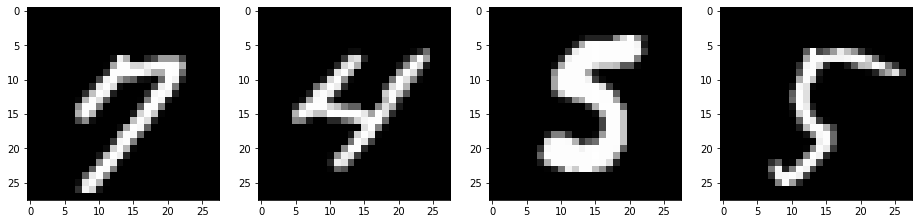

In [24]:
from src.utils.mnist_utils import plot_mnist_testdata 
plot_mnist_testdata()

![model](Images/gcp_training_options-Modelling.jpg)

![](https://ml4a.github.io/images/figures/mnist-input.png)

Why MNIST?
- images need pre-processing
- black and white images are numeric vectors

## 3.A Setup

1. ML Engine Runtimes
2. Repository Structure
3. Configuration Variables
    -  Environment variables to set
    - How to add them to your runtime
4. Setup `gcloud` runtime

Create conda environement
  - `conda env create -f environment.yml -n env_gcp_dl`

### 1 ML Engine Runtimes
Default ML-Engine Runtimes depend on the Tensorflow Version
- [list of runtimes](https://cloud.google.com/ml-engine/docs/tensorflow/runtime-version-list)
- Current Version: `1.12`

In [ ]:
#!pip install tensorflow=1.12

In [2]:
import tensorflow as tf
tf.__version__

'1.12.0'

- current version of gcp datalab
- will be different on Windows machines


### 2. Repository structure

In [34]:
ls | grep "/\|DIR\|yaml"

16-11-2019  16:42    <DIR>          .
16-11-2019  16:42    <DIR>          ..
16-11-2019  16:42               177 config.yaml
27-11-2019  09:28    <DIR>          data
16-11-2019  16:42    <DIR>          doc
27-11-2019  09:18    <DIR>          Images
27-11-2019  09:37    <DIR>          notebook
16-11-2019  16:42    <DIR>          reveal.js
16-11-2019  16:42    <DIR>          src
16-11-2019  16:42    <DIR>          test


Key Directories containing information
```
.
+-- data
+-- src
|  +-- models
|  +-- packages
config.yaml
```

In the next step the contents of [`config.yaml`](config.yaml) will be important

In [35]:
!cat config.yaml

#change at least your project ID
project-id: ml-productive-pipeline-1234
region: europe-west1
bucket: ml-productive-pipeline-1234
tf-version: 1.12
pkg-name: pkg_mnist_fnn


### 3. GCP Environment Variables

- `PROJECT_ID`: unique ID that identifies your project, e.g. **ml-productive-pipeline-12345**
- `BUCKET`: BLOB-store ID. Each project has per default an bucket named by the `PROJECT_ID`
- `REGION`: Which data center to use

In [ ]:
# # #Create config manually and save as yaml:
# config = {}
# config['project-id'] = 'PROJECT'  # # REPLACE WITH YOUR PROJECT ID
# config['region'] = 'europe-west1' # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
# config['bucket'] = 'Bucket-name'  # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
# 
# with open("../config_from_python.yaml", 'wb', encoding= 'utf8') as f:
#     yaml.dump(f)

Additional Environment Variables needed for ML-Engine
- `PKG_NAME`: Package Name which will contain your model
- `TF_VERSION`: Tensorflow Version

In [5]:
import yaml
from pprint import pprint
with open("config.yaml", "r", encoding = "utf8") as f:
    config = yaml.safe_load(f)
pprint(config)

{'bucket': 'bold-circuit-254311',
 'pkg-name': 'pkg_mnist_fnn',
 'project-id': 'bold-circuit-254311',
 'region': 'europe-west1',
 'tf-version': 1.12}


#### Environment variables for project and bucket

Note that:
1. Your project id is the *unique* string that identifies your project (not the project name). You can find this from the GCP Console dashboard's Home page. My dashboard reads:  
     
     - Project ID: ml-productive-pipeline-12345
     
2. Cloud training often involves saving and restoring model files. If you don't have a bucket already, I suggest that you create one from the GCP console (because it will dynamically check whether the bucket name you want is available). A common pattern is to prefix the bucket name by the project id, so that it is unique. Also, for cost reasons, you might want to use a single region bucket.


Add all detail in to [config.yaml](../config.yaml) file in main directory. Missing in public repository.


#### Adding Environment Variables to your runtime
- add variables **persistently**  to the runtime of your kernel from jupyter (or datalab)
- use `os.environ` dictionary

In [6]:
import os
PROJECT = config['project-id'] 
REGION = config['region'] # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
BUCKET = config['bucket'] # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
PKG_NAME = config['pkg-name']

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = str(config['tf-version'])  # Tensorflow version 1.4 before
os.environ['PKG_NAME'] = config['pkg-name']

Now, you can access the environement variable in the terminal where your jupyter, datalab or iphyton.

In [7]:
!echo "Using Tensorflow Version: %TFVERSION%"

"Using Tensorflow Version: 1.12"


### 4. Setup gcloud runtime


In [ ]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

In [50]:
%%cmd
gcloud config set project %PROJECT%
gcloud config set compute/region %REGION%

Microsoft Windows [Version 10.0.17763.864]
(c) 2018 Microsoft Corporation. All rights reserved.

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>gcloud config set project %PROJECT%

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>gcloud config set compute/region %REGION%

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>

Updated property [core/project].
Updated property [compute/region].


### Access Control 

- not necessary if you use 
  - datalab
  - local sdk

- Service Accounts ([Creating and Managing Service Accounts](https://cloud.google.com/iam/docs/creating-managing-service-accounts))
  - need be assigned read/write permission to `BUCKET`

In [12]:
%%bash
conda activate gcp_dl
PROJECT_ID=$PROJECT
AUTH_TOKEN=$(gcloud auth print-access-token)
#echo "Auth-Token: $AUTH_TOKEN
SVC_ACCOUNT=$(curl -X GET -H "Content-Type: application/json" \
    -H "Authorization: Bearer $AUTH_TOKEN" \
    https://ml.googleapis.com/v1/projects/${PROJECT_ID}:getConfig \
    | python -c "import json; import sys; response = json.load(sys.stdin); \
    print(response['serviceAccount'])")
echo "Current Service Account of VM: $SVC_ACCOUNT"
echo "Authorizing the Cloud ML Service account $SVC_ACCOUNT to access files in Bucket: $BUCKET"
gsutil -m defacl ch -u $SVC_ACCOUNT:R gs://$BUCKET
gsutil -m acl ch -u $SVC_ACCOUNT:R -r gs://$BUCKET # error message (if bucket is empty) can be ignored
gsutil -m acl ch -u $SVC_ACCOUNT:W gs://$BUCKET

Process is terminated.


## Beyond Scripting: Packaging up the code

 
Why a package?
 - can be called from other scripts `import model`

Take your code and put into a standard Python package structure, see  [pkg_mnist_fnn/model.py](../src/pkg_mnist_fnn/model.py)

Key-Idea: 
 - define entry point which can be called
 - write all tasks as a function (callable)

### `model.py`

In [ ]:
# %load src/pkg_mnist_fnn/model.py
"""
First try to start Cloud ML

References:
Basic reference for packaging the model so that ml-engine can use it:
- https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/machine_learning/cloudmle/taxifare
MNIST-Estimator-Example:
- https://codeburst.io/use-tensorflow-dnnclassifier-estimator-to-classify-mnist-dataset-a7222bf9f940

ipython -i -m src.models.test_model_estimator_api.mnist_ml_engine -- --data_path=data --output_dir=src\models\test_model_estimator_api\trained --train_steps=100
"""

import tensorflow as tf
import numpy as np

from .utils import load_data
###############################################################################
#Factor into config:
N_PIXEL = 784
OUTDIR = 'trained'
USE_TPU = False
EPOCHS = 5

if USE_TPU:
    _device_update = 'tpu'
else:
    _device_update = 'cpu'

IMAGE_SIZE = 28 * 28
NUM_LABELS = 10
BATCH_SIZE = 128
###############################################################################


def parse_images(x):
    return x.reshape(len(x), -1).astype('float32')


def parse_labels(y):
    return y.astype('int32')


def numpy_input_fn(images: np.ndarray,
                   labels: np.ndarray,
                   mode=tf.estimator.ModeKeys.EVAL):
    """
    Return depending on the `mode`-key an Interator which can be use to feed into
    the Estimator-Model. 

    Alternative if a `tf.data.Dataset` named `dataset` would be created:
    `dataset.make_one_shot_iterator().get_next()`
    """
    if mode == tf.estimator.ModeKeys.TRAIN:
        _epochs = EPOCHS
        _shuffle = True
        _num_threads = 2
    else:
        _epochs = 1
        _shuffle = False
        _num_threads = 1

    return tf.estimator.inputs.numpy_input_fn(
        {'x': images},
        y=labels,
        batch_size=BATCH_SIZE,
        num_epochs=_epochs,
        # Boolean, if True shuffles the queue. Avoid shuffle at prediction time.
        shuffle=_shuffle,
        queue_capacity=1000,
        # Integer, number of threads used for reading and enqueueing. In order to have predicted and repeatable order of reading and enqueueing, such as in prediction and evaluation mode, num_threads should be 1.
        num_threads=_num_threads
    )


def serving_input_fn():
    feature_placeholders = {
        'x': tf.placeholder(tf.float32, shape=[None, N_PIXEL])
    }
    features = feature_placeholders
    return tf.estimator.export.ServingInputReceiver(
         features=features, 
         receiver_tensors=feature_placeholders,
         receiver_tensors_alternatives=None
         )


def train_and_evaluate(args):
    """
    Utility function for distributed training on ML-Engine
    https://www.tensorflow.org/api_docs/python/tf/estimator/train_and_evaluate 
    """
    ##########################################
    # Load Data in Memoery
    # ToDo: replace numpy-arrays
    (x_train, y_train), (x_test, y_test) = load_data(
        rel_path=args['data_path'])
  
    x_train = parse_images(x_train)
    x_test = parse_images(x_test)

    y_train = parse_labels(y_train)
    y_test = parse_labels(y_test)

    model = tf.estimator.DNNClassifier(
        hidden_units=[256, 128, 64],
        feature_columns=[tf.feature_column.numeric_column(
            'x', shape=[N_PIXEL, ])],
        model_dir=args['output_dir'],
        n_classes=10,
        optimizer=tf.train.AdamOptimizer,
        # activation_fn=,
        dropout=0.2,
        batch_norm=False,
        loss_reduction='weighted_sum',
        warm_start_from=None,
        config = None
    )
   
    train_spec = tf.estimator.TrainSpec(
        input_fn=numpy_input_fn(
            x_train, y_train, mode=tf.estimator.ModeKeys.TRAIN),
        max_steps=args['train_steps'],
        hooks = None
    )
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
    eval_spec = tf.estimator.EvalSpec(
        input_fn=numpy_input_fn(
            x_test, y_test, mode=tf.estimator.ModeKeys.EVAL),
        steps=None,
        start_delay_secs=args['eval_delay_secs'],
        throttle_secs=args['min_eval_frequency'],
        exporters=exporter
    )
    tf.estimator.train_and_evaluate(
        estimator=model, train_spec=train_spec, eval_spec=eval_spec)

### `task.py`

In [ ]:
# %load src/pkg_mnist_fnn/task.py
"""
Parse arguments and call main function
"""
import os
import argparse
import shutil

from .model import train_and_evaluate

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--data_path',
        help='GCS or local path to training data',
        required=True
    )
    parser.add_argument(
        '--output_dir',
        help='GCS location to write checkpoints and export models',
        required=True
    )
    parser.add_argument(
        '--train_batch_size',
        help='Batch size for training steps',
        type=int,
        default='128'
    )
    parser.add_argument(
        '--train_steps',
        help='Steps to run the training job for',
        type=int,
        default='200'
    )
    parser.add_argument(
        '--hidden_units',
        help='List of hidden layer sizes to use for DNN feature columns',
        nargs='+',
        type=int,
        default=[128, 64, 32]
    )
    parser.add_argument(
        '--job_dir',
        help='this model ignores this field, but it is required by gcloud',
        default='junk'
    )
    # Eval arguments
    parser.add_argument(
        '--eval_delay_secs',
        help='How long to wait before running first evaluation',
        default=1,
        type=int
    )
    parser.add_argument(
        '--min_eval_frequency',
        help='Seconds between evaluations',
        default=10,
        type=int
    )

    args = parser.parse_args().__dict__

    OUTDIR = args['output_dir']
    # #######################################
    # # Train and Evaluate (use TensorBoard to visualize)
    train_and_evaluate(args)

# 3.B Train using ML-Engine on

### your local machine
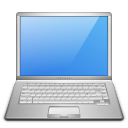 

1. Call your python script (module)
2. Use `gcloud ml-engine local train`

### a cluster of machines using ML-Engine service

3. Use `gcloud ml-engine train`

### Modeling and ML-Engine

- Environment Variables with absolut paths to relevant folders: 
    - `PWD`: where your project folder lies
    - `PKG_NAME`: Self-Contained Package to be exported into `site-packages` in `venv`
    - `trained`: Where to store checkpoints (logs, weights, graph)

In [99]:
%%bash
echo "Working Directory:     $PWD"
echo "Local data Directory:  $PWD/data"
echo "Package Directory:     $PWD/src/$PKG_NAME"
echo "Saved Model Directory: $PWD/src/$PKG_NAME/trained/"
rm -rf $PWD/src/$PKG_NAME/trained/ # start fresh
echo "Erased previously saved models"

Working Directory:     /home/enryh/proj_DL_models_and_pipelines_with_GCP
Local data Directory:  /home/enryh/proj_DL_models_and_pipelines_with_GCP/data
Package Directory:     /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn
Saved Model Directory: /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained/
Erased previously saved models


In [9]:
%%cmd
echo "Working Directory:     %cd%"
echo "Local data Directory:  %cd%/data"
echo "Package Directory:     %cd%/src/%PKG_NAME%"
echo "Saved Model Directory: %cd%/trained/%PKG_NAME%/trained/"
rm -rf %PWD%/trained/%PKG_NAME%/trained/ # start fresh
echo "Erased previously saved models"

Microsoft Windows [Version 10.0.17763.864]
(c) 2018 Microsoft Corporation. All rights reserved.

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>echo "Working Directory:     %cd%"
"Working Directory:     c:\Users\kzl465\Documents\gcp_ml_engine_talk"

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>echo "Local data Directory:  %cd%/data"
"Local data Directory:  c:\Users\kzl465\Documents\gcp_ml_engine_talk/data"

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>echo "Package Directory:     %cd%/src/%PKG_NAME%"
"Package Directory:     c:\Users\kzl465\Documents\gcp_ml_engine_talk/src/pkg_mnist_fnn"

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>echo "Saved Model Directory: %cd%/trained/%PKG_NAME%/trained/"
"Saved Model Directory: c:\Users\kzl465\Documents\gcp_ml_engine_talk/trained/pkg_mnist_fnn/trained/"

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>rm -rf %PWD%/trained/%PKG_NAME%/trained/ # start fresh

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_ta

## 1. Running the Python `module` without gcp ml-engine

- Entry point is defined in `task.py`
  - parses command line arguments 
- conda env has to be active

In [100]:
%%bash
conda activate gcp_dl
rm -rf $PKG_NAME.tar.gz ${PWD}/$PKG_NAME/trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/../  
echo "Python Package Path: src.${PKG_NAME}.task"

Python Package Path: src.pkg_mnist_fnn.task


In [57]:
%%cmd
conda activate activate gcp_dl
rm -rf %PKG_NAME%.tar.gz %PWD%/%PKG_NAME%/trained
#export PYTHONPATH=%PYTHONPATH%:%cd%/../  
echo "Python Package Path: src.%PKG_NAME%.task"

Microsoft Windows [Version 10.0.17763.864]
(c) 2018 Microsoft Corporation. All rights reserved.

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>conda activate activate gcp_dl

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>rm -rf %PKG_NAME%.tar.gz %PWD%/%PKG_NAME%/trained

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>#export PYTHONPATH=%PYTHONPATH%:%cd%/../  

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>echo "Python Package Path: src.%PKG_NAME%.task"
"Python Package Path: src.pkg_mnist_fnn.task"

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>

Could not find conda environment: gcp_dl
You can list all discoverable environments with `conda info --envs`.

'#export' is not recognized as an internal or external command,
operable program or batch file.


In [125]:
%%bash
conda activate env_gcp_dl
python -m src.${PKG_NAME}.task \
   --data_path="${PWD}/data" \
   --output_dir=${PWD}/src/${PKG_NAME}/trained \
   --train_steps=1000 \
   --job_dir=tmp
echo "Saved model: ${PWD}/src/${PKG_NAME}/trained/export/exporter/ "

Saved model: /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained/export/exporter/ 


In [14]:
%%cmd
conda activate activate env_gcp_dl
python -m src.%PKG_NAME%.task ^
   --data_path="%cd%\data" ^
   --output_dir=%cd%\trained\%PKG_NAME%\script ^
   --train_steps=1000 ^
   --job_dir=tmp
echo "Saved model: %cd%\trained\%PKG_NAME%\trained\export\exporter\ "

Microsoft Windows [Version 10.0.17763.864]
(c) 2018 Microsoft Corporation. All rights reserved.

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>conda activate activate env_gcp_dl

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>python -m src.%PKG_NAME%.task ^
More?    --data_path="%cd%\data" ^
More?    --output_dir=%cd%\trained\%PKG_NAME%\script ^
More?    --train_steps=1000 ^
More?    --job_dir=tmp

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>echo "Saved model: %cd%\trained\%PKG_NAME%\trained\export\exporter\ "
"Saved model: c:\Users\kzl465\Documents\gcp_ml_engine_talk\trained\pkg_mnist_fnn\trained\export\exporter\ "

(env_gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>

#### Saved Model

In [136]:
%%bash
DATE=$(ls $PWD/src/$PKG_NAME/trained/export/exporter/ |tail -1)
echo "Date as integer: $DATE"
echo 
date -d @${DATE}

Date as integer: 1551195228

Tue Feb 26 16:33:48 CET 2019


In [10]:
%%cmd
dir %cd%\trained\%PKG_NAME%\script\export\exporter\

Microsoft Windows [Version 10.0.17763.864]
(c) 2018 Microsoft Corporation. All rights reserved.

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>dir %cd%\trained\%PKG_NAME%\script\export\exporter\
 Volume in drive C is OSDisk
 Volume Serial Number is F84C-EE4C

 Directory of c:\Users\kzl465\Documents\gcp_ml_engine_talk\trained\pkg_mnist_fnn\script\export\exporter

27-11-2019  10:06    <DIR>          .
27-11-2019  10:06    <DIR>          ..
27-11-2019  10:06    <DIR>          1574845584
               0 File(s)              0 bytes
               3 Dir(s)  19.413.389.312 bytes free

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>

#### And we would be ready to deploy

... but of course not without looking at performance metrics or predictions!

## 2. Training using `gcloud ml-engine local train`

- continue training using `ml-engine local`

In [105]:
%%bash
conda activate gcp_dl
gcloud ml-engine local train \
   --module-name=${PKG_NAME}.task \
   --package-path=${PWD}/src/${PKG_NAME} \
   -- \
   --data_path="${PWD}/data" \
   --output_dir=${PWD}/trained/${PKG_NAME}/local \
   --train_steps=2000 \
   --job_dir=./tmp

In [15]:
%%cmd
conda activate gcp_dl
gcloud ml-engine local train ^
   --module-name=%PKG_NAME%.task ^
   --package-path=%cd%\src\%PKG_NAME% ^
   -- ^
   --data_path="%cd%\data" ^
   --output_dir=%cd%\trained\%PKG_NAME%\local ^
   --train_steps=2000 ^
   --job_dir=.\tmp

Microsoft Windows [Version 10.0.17763.864]
(c) 2018 Microsoft Corporation. All rights reserved.

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>conda activate gcp_dl

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>gcloud ml-engine local train ^
More?    --module-name=%PKG_NAME%.task ^
More?    --package-path=%cd%\src\%PKG_NAME% ^
More?    -- ^
More?    --data_path="%cd%\data" ^
More?    --output_dir=%cd%\trained\%PKG_NAME%\trained ^
More?    --train_steps=2000 ^
More?    --job_dir=.\tmp

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2019-11-27 10:53:54.667011: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2019-11-27 10:53:54.669863: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


In [16]:
!gcloud ml-engine local train  --help

NAME
    gcloud ml-engine local train - run an AI Platform training job locally

SYNOPSIS
    gcloud ml-engine local train --module-name=MODULE_NAME [--distributed]
        [--job-dir=JOB_DIR] [--package-path=PACKAGE_PATH]
        [--parameter-server-count=PARAMETER_SERVER_COUNT]
        [--start-port=START_PORT; default=27182] [--worker-count=WORKER_COUNT]
        [GCLOUD_WIDE_FLAG ...] [-- USER_ARGS ...]

DESCRIPTION
    This command runs the specified module in an environment similar to that of
    a live AI Platform Training Job.

    This is especially useful in the case of testing distributed models, as it
    allows you to validate that you are properly interacting with the AI
    Platform cluster configuration. If your model expects a specific number of
    parameter servers or workers (i.e. you expect to use the CUSTOM machine
    type), use the --parameter-server-count and --worker-count flags to further
    specify the desired cluster configuration, just as you would in your

## Training Cloud using `gcloud ml-engine train`

- a copy of the data is in Google Storage (buckets)
- `gcloud ml-engine` output is saved to `OUTDIR`in Google Storage 
  - checkpoints (logs)
  - model graph and weights
- data is copied to Google Storage
  
> NOTE: No with-spaces behind line break symbol **\**


In [17]:
!gsutil -m rm -rf gs://$BUCKET/$PKG_NAME/*

CommandException: 1 files/objects could not be removed.


In [18]:
# 10 epochs in global steps:

steps = 10000
batch_size = 128
n_train = 60000
print("Number of epochs using {} steps: {:.1f}".format(steps, steps * batch_size / n_train))
steps = int(60000 / 128 * 10) + 1
print("For ten epochs specify {} steps".format(steps))

Number of epochs using 10000 steps: 21.3
For ten epochs specify 4688 steps


In [19]:
OUTDIR = '/'.join(['gs:/', BUCKET, PKG_NAME, 'trained'])
os.environ['OUTDIR'] = OUTDIR

In [139]:
!gsutil -m cp ${PWD}/data/mnist/raw/mnist.npz gs://${BUCKET}/$PKG_NAME/data/mnist.npz

Copying file:///home/enryh/proj_DL_models_and_pipelines_with_GCP/data/mnist/raw/mnist.npz [Content-Type=application/octet-stream]...
/ [1/1 files][ 11.0 MiB/ 11.0 MiB] 100% Done                                    
Operation completed over 1 objects/11.0 MiB.                                     


In [23]:
!gsutil -m cp %cd%\data\mnist\raw\mnist.npz gs://%BUCKET%/%PKG_NAME%/data/mnist.npz

Copying file://c:\Users\kzl465\Documents\gcp_ml_engine_talk\data\mnist\raw\mnist.npz [Content-Type=application/octet-stream]...
/ [0/1 files][    0.0 B/ 11.0 MiB]   0% Done                                    
-
- [0/1 files][  1.3 MiB/ 11.0 MiB]  11% Done                                    
\
|
| [0/1 files][  4.9 MiB/ 11.0 MiB]  44% Done                                    
/
/ [0/1 files][  8.5 MiB/ 11.0 MiB]  77% Done                                    
-
\
\ [1/1 files][ 11.0 MiB/ 11.0 MiB] 100% Done                                    

Operation completed over 1 objects/11.0 MiB.                                     


In [107]:
%%bash
OUTDIR=gs://${BUCKET}/$PKG_NAME/trained
JOBNAME=mnist_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=$PKG_NAME.task \
   --package-path=${PWD}/src/$PKG_NAME \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --python-version 3.5 \
   --runtime-version=$TFVERSION \
   -- \
   --data_path="gs://${BUCKET}/$PKG_NAME/data/" \
   --output_dir=$OUTDIR \
   --train_steps=5000 \
   --job_dir=$OUTDIR/jobs 

gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained europe-west1 mnist_190226_153903
jobId: mnist_190226_153903
state: QUEUED


Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/#1551189625396791...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/checkpoint#1551189632535194...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/eval/events.out.tfevents.1551189555.cmle-training-15024654005366275538#1551189558325794...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/eval/#1551189555184899...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/events.out.tfevents.1551189473.cmle-training-15024654005366275538#1551189583874752...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/eval/events.out.tfevents.1551189639.cmle-training-2556488161313260297#1551189642061761...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/events.out.tfevents.1551189596.cmle-training-2556488161313260297#1551189666903395...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/export/#1551189561488413...
Removing gs://ml-produ

In [34]:
%%script powershell
date +%y%m%d_%H%M%S

Windows PowerShell 
Copyright (C) Microsoft Corporation. All rights reserved.

(base) PS C:\Users\kzl465\Documents\gcp_ml_engine_talk> date +%y%m%d_%H%M%S
191127_122505
(base) PS C:\Users\kzl465\Documents\gcp_ml_engine_talk> 

Loading personal and system profiles took 1105ms.


In [31]:
%qtconsole

In [36]:
%%cmd
set OUTDIR=gs://%BUCKET%/%PKG_NAME%/trained
#JOBNAME=mnist_$(date -u +%y%m%d_%H%M%S)
set JOBNAME=mnist_201911271216
echo %OUTDIR% %REGION% %JOBNAME%
gsutil -m rm -rf %OUTDIR%
gcloud ml-engine jobs submit training %JOBNAME% ^
   --region=%REGION% ^
   --module-name=%PKG_NAME%.task ^
   --package-path=%cd%\src\%PKG_NAME% ^
   --staging-bucket=gs://%BUCKET% ^
   --scale-tier=BASIC ^
   --python-version 3.5 ^
   --runtime-version=%TFVERSION% ^
   -- ^
   --data_path="gs://%BUCKET%/%PKG_NAME%/data/" ^
   --output_dir=%OUTDIR% ^
   --train_steps=5000 ^
   --job_dir=%OUTDIR%/jobs 

Microsoft Windows [Version 10.0.17763.864]
(c) 2018 Microsoft Corporation. All rights reserved.

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>set OUTDIR=gs://%BUCKET%/%PKG_NAME%/trained

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>set JOBNAME=mnist_201911271216

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>echo %OUTDIR% %REGION% %JOBNAME%
gs://bold-circuit-254311/pkg_mnist_fnn/trained europe-west1 mnist_201911271216

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>gsutil -m rm -rf %OUTDIR%

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>gcloud ml-engine jobs submit training %JOBNAME% ^
More?    --region=%REGION% ^
More?    --module-name=%PKG_NAME%.task ^
More?    --package-path=%cd%\src\%PKG_NAME% ^
More?    --staging-bucket=gs://%BUCKET% ^
More?    --scale-tier=BASIC ^
More?    --python-version 3.5 ^
More?    --runtime-version=%TFVERSION% ^
More?    -- ^
More?    --data_path="gs://%BUCKET%/%PKG_NAME%/data/" ^
More?    --output_dir=%OUTDIR% ^
Mo

CommandException: 1 files/objects could not be removed.
Job [mnist_201911271216] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe mnist_201911271216

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs mnist_201911271216


In [38]:
!gcloud ai-platform jobs stream-logs mnist_201911271216

INFO	2019-11-27 12:26:15 +0100	service		Validating job requirements...
INFO	2019-11-27 12:26:15 +0100	service		Job creation request has been successfully validated.
INFO	2019-11-27 12:26:15 +0100	service		Job mnist_201911271216 is queued.
INFO	2019-11-27 12:26:16 +0100	service		Waiting for job to be provisioned.
INFO	2019-11-27 12:26:19 +0100	service		Waiting for training program to start.
INFO	2019-11-27 12:27:49 +0100	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://bold-circuit-254311/mnist_201911271216/4cd112f8a7c61f356de65e84f64e8c4994cba72d7f040f6a2fa51b9cc588d860/pkg_mnist_fnn-0.0.0.tar.gz"],  "python_module": "pkg_mnist_fnn.task",  "args": ["--data_path\u003dgs://bold-circuit-254311/pkg_mnist_fnn/data/", "--output_dir\u003dgs://bold-circuit-254311/pkg_mnist_fnn/trained", "--train_steps\u003d5000", "--job_dir\u003dgs://bold-circuit-254311/pkg_mnist_fnn/trained/jobs"],  "r

### Fetch logs from ml-engine job

In [46]:
!gcloud ai-platform jobs describe mnist_201911271216

createTime: '2019-02-26T13:56:16Z'
etag: xa9JtMyFgys=
jobId: mnist_190226_135612
startTime: '2019-02-26T13:57:04Z'
state: RUNNING
trainingInput:
  args:
  - --data_path=gs://ml-productive-pipeline-53122/pkg_mnist_fnn/
  - --output_dir=gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained
  - --train_steps=5000
  - --job_dir=gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/jobs
  packageUris:
  - gs://ml-productive-pipeline-53122/mnist_190226_135612/dbf14cd8277aeba054056ee160e13d2f2d798a9f82dfd5b3b76d289e7a0284c8/pkg_mnist_fnn-0.0.0.tar.gz
  pythonModule: pkg_mnist_fnn.task
  pythonVersion: '3.5'
  region: europe-west1
  runtimeVersion: '1.12'
trainingOutput:
  consumedMLUnits: 0.03

View job in the Cloud Console at:
https://console.cloud.google.com/ml/jobs/mnist_190226_135612?project=ml-productive-pipeline-53122

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fmnist_190226_135612&project=ml-productive-pipeline-53122


In [47]:
!gcloud ai-platform jobs stream-logs mnist_201911271216

INFO	2019-02-26 14:56:16 +0100	service		Validating job requirements...
INFO	2019-02-26 14:56:16 +0100	service		Job creation request has been successfully validated.
INFO	2019-02-26 14:56:16 +0100	service		Waiting for job to be provisioned.
INFO	2019-02-26 14:56:16 +0100	service		Job mnist_190226_135612 is queued.
INFO	2019-02-26 14:56:21 +0100	service		Waiting for training program to start.
INFO	2019-02-26 14:57:30 +0100	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://ml-productive-pipeline-53122/mnist_190226_135612/dbf14cd8277aeba054056ee160e13d2f2d798a9f82dfd5b3b76d289e7a0284c8/pkg_mnist_fnn-0.0.0.tar.gz"],  "python_module": "pkg_mnist_fnn.task",  "args": ["--data_path\u003dgs://ml-productive-pipeline-53122/pkg_mnist_fnn/", "--output_dir\u003dgs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained", "--train_steps\u003d5000", "--job_dir\u003dgs://ml-productive-pipeline-53122/

Don't be concerned if the notebook appears stalled (with a blue progress bar) or returns with an error about being unable to refresh auth tokens. This is a long-lived Cloud job and work is going on in the cloud. 

**Use the Cloud Console link to monitor the job and do NOT proceed until the job is done.**

## Check Results in TensorBoard

- In Datalab Tensorboard is available using a special package. On your local machine, you can execute tensorflow using the command line.

In Datalab Tensorboard is available using a special package. On your local machine, you can execute tensorflow using the command line.

DATALAB:

In [ ]:
from google.datalab.ml import TensorBoard
TensorBoard().start(('{}/'+os.environ['PKG_NAME']).format(os.environ['PWD']))

In [ ]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

If the above step (to stop TensorBoard) appears stalled, just move on to the next step. You don't need to wait for it to return.

Local Machine: `tensorboard --logdir /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained`

In [59]:
%%bash
conda activate gcp_dl
tensorboard --logdir $PWD/src/$PKG_NAME/trained

Process is terminated.


In [ ]:
%%cmd
conda activate gcp_dl
tensorboard --logdir %cd%\trained\%PKG_NAME%\trained

In [ ]:
%%bash
#gcloud auth application-default login
echo $OUTDIR
tensorboard --logdir $OUTDIR

In [ ]:
%%cmd
#gcloud auth application-default login
echo %OUTDIR%
tensorboard --logdir %OUTDIR%

# Deploy model - from any previous step

- `tf.estimator.LatestExporter`is used to store a model for deployment in the cloud
- See also:  `tf.estimator.export`, `tf.saved_model`

[Link to Console](https://console.cloud.google.com/)

In [115]:
%%bash
gsutil ls gs://${BUCKET}/${PKG_NAME}/trained/export/exporter 

gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/export/exporter/
gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/export/exporter/1551195744/


In [22]:
%%cmd
gsutil ls gs://%BUCKET%/%PKG_NAME%/trained/export/exporter 

UsageError: Cell magic `%%powershell` not found.


Identifier for deployed model:
- `MODEL_NAME`
- `MODEL_VERSION`

In [111]:
%%bash
MODEL_NAME="MNIST_MLENGINE"
MODEL_VERSION="v3" 
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/$PKG_NAME/trained/export/exporter | tail -1)
echo "Run these commands one-by-one (the very first time, you'll create a model and then create a version)"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models   create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version $TFVERSION

Run these commands one-by-one (the very first time, you'll create a model and then create a version)


ERROR: (gcloud.ml-engine.models.create) Resource in project [ml-productive-pipeline-53122] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name
Creating version (this might take a few minutes)......
..............................................................................................done.


In [44]:
!gsutil ls gs://%BUCKET%/%PKG_NAME%/trained/export/exporter

gs://bold-circuit-254311/pkg_mnist_fnn/trained/export/exporter/
gs://bold-circuit-254311/pkg_mnist_fnn/trained/export/exporter/1574854154/


In [45]:
%%cmd
set MODEL_NAME="MNIST_MLENGINE"
set MODEL_VERSION="v1" 
set NAME=1574854154
set MODEL_LOCATION=gs://%BUCKET%/%PKG_NAME%/trained/export/exporter/1574854154

echo "Run these commands one-by-one (the very first time, you'll create a model and then create a version)"
# gcloud ml-engine versions delete %MODEL_VERSION% --model %MODEL_NAME%
# gcloud ml-engine models delete %MODEL_NAME%
gcloud ml-engine models   create %MODEL_NAME% --regions %REGION%
gcloud ml-engine versions create %MODEL_VERSION% --model %MODEL_NAME% --origin %MODEL_LOCATION% --runtime-version %TFVERSION%

Microsoft Windows [Version 10.0.17763.864]
(c) 2018 Microsoft Corporation. All rights reserved.

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>set MODEL_NAME="MNIST_MLENGINE"

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>set MODEL_VERSION="v1" 

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>set NAME=1574854154

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>set MODEL_LOCATION=gs://%BUCKET%/%PKG_NAME%/trained/export/exporter/1574854154

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>
(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>echo "Run these commands one-by-one (the very first time, you'll create a model and then create a version)"
"Run these commands one-by-one (the very first time, you'll create a model and then create a version)"

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk># gcloud ml-engine versions delete %MODEL_VERSION% --model %MODEL_NAME%

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk># gcloud ml-engine models 

'#' is not recognized as an internal or external command,
operable program or batch file.
'#' is not recognized as an internal or external command,
operable program or batch file.
ERROR: (gcloud.ml-engine.models.create) Resource in project [bold-circuit-254311] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name
Creating version (this might take a few minutes)......
...............................................................................................................................................................................................................................................................................................................................................................................................................................................

# Predictions

1. Using the Model saved by Python Module
2. Using Model saved by `ml-engine local`
3. Using Model trained online

Tools get predictions:
- Command Line Interfaces
    - `gcloud ml-engine local predict`
    - `gcloud ml-engine predict`
- Python Client

### Let's look again at our four examples

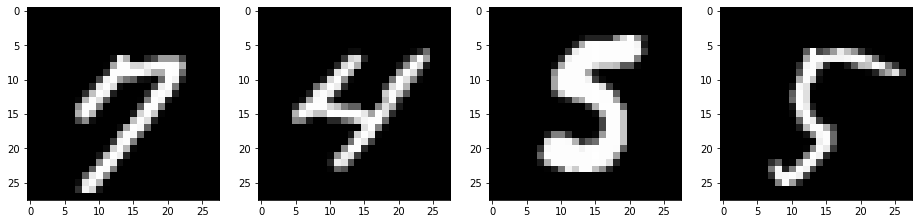

In [47]:
from src.utils.mnist_utils import plot_mnist_testdata
plot_mnist_testdata()

## ML-Engine: `ml-engine local predict`
- Using Model saved
  - Python module
  - `ml-engine local`

### `ML-Engine local` using Python 3 ...
you still have to remove manually some compiled python files

In [ ]:
!ls /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/

In order to work with `Python 3`, delete the `*.pyc` files, see [post](https://stackoverflow.com/questions/48824381/gcloud-ml-engine-local-predict-runtimeerror-bad-magic-number-in-pyc-file)

Default Datalab
```
rm /tools/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
```
Default UNIX:
```
sudo rm /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
```

> Process running Datalab or Jupyter Notebook needs admin rights. This is not always given for locally run notebooks

In [ ]:
%%bash
# #remove any pyc files: Using Python3 you have to recompile
# #Note: you need admin rights
rm /tools/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
# sudo rm /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc 

In [117]:
%%bash
conda activate gcp_dl
model_dir=$(ls $PWD/src/$PKG_NAME/trained/export/exporter/ | tail -1)
echo "Selected Model:  $model_dir" 
gcloud ml-engine local predict \
    --model-dir=${PWD}/src/${PKG_NAME}/trained/export/exporter/${model_dir} \
    --json-instances=./data/test.json \
    --verbosity debug > data/test_predictions
cat data/test_predictions

Selected Model:  1551195228
CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                    PROBABILITIES
[7]        [u'7']   [10.159305572509766, 12.954800605773926, 11.682648658752441, 13.86036205291748, 25.222925186157227, 7.880295276641846, -3.0875470638275146, 39.66598892211914, 10.021535873413086, 31.613039016723633]    [1.5320462455094275e-13, 2.508069489939868e-12, 7.028310767577539e-13, 6.2032701024505865e-12, 5.337264497029537e-07, 1.5685923629329794e-14, 2.705433004601221e-19, 0.9996814727783203, 1.334870934491597e-13, 0.0003180606581736356]
[4]        [u'4']   [15.225436210632324, 9.730201721191406, 23.877195358276367, 10.366071701049805, 55.04463195800781, 25.375831604003906, 4.700004577636719, 11.3602294921875, 20.23716926574707, 36.84248352050781]         [5.0903007448063715e-18, 2.09022482340398e-20, 2.911751311525

DEBUG: Running [gcloud.ml-engine.local.predict] with arguments: [--json-instances: "./data/test.json", --model-dir: "/home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained/export/exporter/1551195228", --verbosity: "debug"]
2019-02-26 16:48:35.700984: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.

INFO: Display format: "default 
          table(
              predictions:format="table(
                  class_ids, classes, logits, probabilities
              )"
          )"
DEBUG: SDK update checks are disabled.


In [ ]:
%%bash
gcloud ml-engine local predict --help

## Online Prediction - Command Line

- same output format as before

In [118]:
%%bash
gcloud ml-engine predict --model=MNIST_MLENGINE --version=v1 --json-instances=data/test.json

CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                    PROBABILITIES
[7]        [u'7']   [22.002077102661133, 4.273345470428467, 24.17157745361328, 24.138999938964844, 28.22089195251465, 23.208688735961914, 3.522111415863037, 42.038028717041016, 16.697460174560547, 34.3787841796875]        [1.9874284440390966e-09, 3.970099341190314e-17, 1.739776855913533e-08, 1.6840123961969766e-08, 9.97903271127143e-07, 6.6422662925447185e-09, 1.8730255928538357e-17, 0.9995274543762207, 9.874739914650377e-12, 0.00047144072595983744]
[4]        [u'4']   [11.610347747802734, 10.453926086425781, 18.951528549194336, 3.513504981994629, 41.507911682128906, 4.462229251861572, 18.024948120117188, 25.706693649291992, 16.08464241027832, 24.898889541625977]     [1.036699412838675e-13, 3.261559655708991e-14, 1.5991424850980707e-10, 3.156736284461617

In [48]:
%%cmd
gcloud ml-engine predict --model=MNIST_MLENGINE --version=v1 --json-instances=data\test.json

Microsoft Windows [Version 10.0.17763.864]
(c) 2018 Microsoft Corporation. All rights reserved.

(gcp_dl) c:\Users\kzl465\Documents\gcp_ml_engine_talk>gcloud ml-engine predict --model=MNIST_MLENGINE --version=v1 --json-instances=data\test.json
CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                   PROBABILITIES
[7]        [u'7']   [17.58386993408203, 16.07724952697754, 16.789281845092773, 21.36930274963379, 21.408531188964844, 14.824420928955078, -10.157759666442871, 45.70421600341797, 17.613882064819336, 36.35768127441406]     [6.129866037506149e-13, 1.358732733530016e-13, 2.769272712619536e-13, 2.700496076757375e-11, 2.8085376038711196e-11, 3.881838833664705e-14, 5.487997835324243e-25, 0.9999127388000488, 6.316624740626553e-13, 8.725967927603051e-05]
[4]        [u'4']   [-28.75107192993164, 3.4247384071350098, 0.55023247

> Check Console

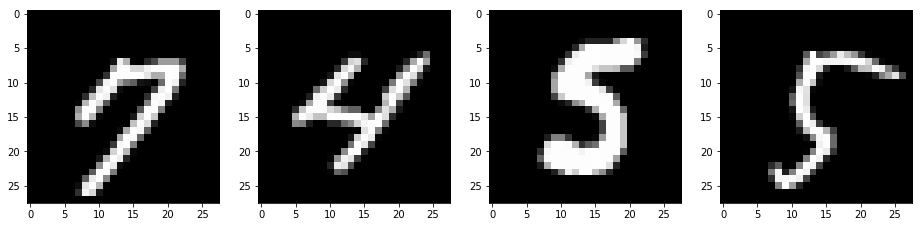

In [85]:
plot_mnist_testdata()

## Online Prediction - Python Client

- Get predictions using the [Python-Client-Library, see Tutorial](https://cloud.google.com/ml-engine/docs/tensorflow/python-client-library). 

- [API-Reference](https://cloud.google.com/ml-engine/reference/rest/)

-  service account authentification:  [link](https://cloud.google.com/iam/docs/creating-managing-service-accounts)

In [ ]:
# %bash
# export GOOGLE_APPLICATION_CREDENTIALS=$PWD/ML-productive-pipeline-53122-64d3c31786e7.json
# echo $GOOGLE_APPLICATION_CREDENTIALS

In [55]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../My First Project-be9253caf389.json'

In [51]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import json

In [52]:
%pdoc discovery.build

Class docstring:
    Construct a Resource for interacting with an API.
    
    Construct a Resource object for interacting with an API. The serviceName and
    version are the names from the Discovery service.
    
    Args:
      serviceName: string, name of the service.
      version: string, the version of the service.
      http: httplib2.Http, An instance of httplib2.Http or something that acts
        like it that HTTP requests will be made through.
      discoveryServiceUrl: string, a URI Template that points to the location of
        the discovery service. It should have two parameters {api} and
        {apiVersion} that when filled in produce an absolute URI to the discovery
        document for that service.
      developerKey: string, key obtained from
        https://code.google.com/apis/console.
      model: googleapiclient.Model, converts to and from the wire format.
      requestBuilder: googleapiclient.http.HttpRequest, encapsulator for an HTTP
        request.
      

```
Signature: discovery.build(serviceName, version, http=None, discoveryServiceUrl='https://www.googleapis.com/discovery/v1/apis/{api}/{apiVersion}/rest', developerKey=None, model=None, requestBuilder=<class 'googleapiclient.http.HttpRequest'>, credentials=None, cache_discovery=True, cache=None)
Docstring:
Construct a Resource for interacting with an API.

Construct a Resource object for interacting with an API. The serviceName and
version are the names from the Discovery service.

Args:
serviceName: string, name of the service.
version: string, the version of the service.
http: httplib2.Http, An instance of httplib2.Http or something that acts
like it that HTTP requests will be made through.
discoveryServiceUrl: string, a URI Template that points to the location of
the discovery service. It should have two parameters {api} and
{apiVersion} that when filled in produce an absolute URI to the discovery
document for that service.
developerKey: string, key obtained from
https://code.google.com/apis/console.
model: googleapiclient.Model, converts to and from the wire format.
requestBuilder: googleapiclient.http.HttpRequest, encapsulator for an HTTP
request.
credentials: oauth2client.Credentials or
google.auth.credentials.Credentials, credentials to be used for
authentication.
cache_discovery: Boolean, whether or not to cache the discovery doc.
cache: googleapiclient.discovery_cache.base.CacheBase, an optional
cache object for the discovery documents.

Returns:
A Resource object with methods for interacting with the service.
File: /usr/local/envs/py3env/lib/python3.5/site-packages/googleapiclient/discovery.py
Type: function
```

In [56]:
api = discovery.build(serviceName='ml', version='v1',
                      http=None, 
                      discoveryServiceUrl='https://www.googleapis.com/discovery/v1/apis/{api}/{apiVersion}/rest', 
                      developerKey=None, 
                      model=None, 
                      #requestBuilder=<class 'googleapiclient.http.HttpRequest'>, 
                      credentials=None, 
                      cache_discovery=True, 
                      cache=None)

In [57]:
MODEL_NAME = 'MNIST_MLENGINE'
VERSION = 'v1'

In [59]:
# Load data
from src.pkg_mnist_fnn.utils import load_data
from src.pkg_mnist_fnn.model import parse_images
import numpy as np
(_,_), (x_test, y_test) = load_data(rel_path='data')
N=4
test_indices = np.random.randint(low=0, high=len(y_test), size=N)
x_test, y_test = x_test[test_indices], y_test[test_indices]
x_test = parse_images(x_test).tolist()

n_lines = len(y_test)
instances = []
with open("data/test.json", "r") as f:
    for image, label in zip(x_test, y_test):
        instances.append({"x": image}) #, "y": int(label)}

In [60]:
project_id = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION)
request_data = {"instances":
    instances
}
request = api.projects().predict(body=request_data, name=project_id).execute()
print(request)

{'predictions': [{'probabilities': [3.2548705064527894e-08, 6.108047728048405e-06, 0.9999655485153198, 1.1024923878721893e-05, 5.7965403310600294e-11, 1.91313587194486e-09, 1.9485177360500927e-10, 1.5596122466376983e-05, 1.709668367766426e-06, 1.3262202891439756e-08], 'class_ids': [2], 'classes': ['2'], 'logits': [0.5153061151504517, 5.749931335449219, 17.755800247192383, 6.34048318862915, -5.815340995788574, -2.318687915802002, -4.602946758270264, 6.687346458435059, 4.476623058319092, -0.3825138807296753]}, {'probabilities': [1.0069890095110168e-06, 0.0005521674174815416, 0.9946444034576416, 0.00029257481219246984, 2.549663076933939e-05, 1.1414009577492834e-06, 5.156581828202889e-10, 0.004440957680344582, 4.185155194136314e-05, 3.3194842785633227e-07], 'class_ids': [2], 'classes': ['2'], 'logits': [-1.7603847980499268, 4.546502113342285, 12.042791366577148, 3.9113714694976807, 1.4711973667144775, -1.6350926160812378, -9.337416648864746, 6.6312761306762695, 1.9667797088623047, -2.87012

In [61]:
for i, pred in enumerate(request['predictions']):
    print("Predicted class: {}, True Class:\t{}".format(pred['classes'][0], y_test[i]))

Predicted class: 2, True Class:	2
Predicted class: 2, True Class:	2
Predicted class: 4, True Class:	4
Predicted class: 7, True Class:	7


# Recap

## Outlook
- Add different models types
    - different layers of abstraction in tensorflow
    - sklearn
- Show how to use `ml-engine` in SQL in BigQuery

# Appendix

#### Notes on Jupyter Slides
- Activate: View -> Cell Toolbar -> Slideshow
- Install [nbextensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html) into `base` conda environment
   - activate [split cells vertically](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/splitcell/readme.html)
   
- [RISE](https://rise.readthedocs.io/en/5.4.1/installation.html) for interactive presentations
  - using conda: `conda install -c damianavila82 rise`
  - activte scrolling in Notebook-Metadata, see [link](https://rise.readthedocs.io/en/5.4.1/customize.html#config-right-scroll) 
  - adapt width and height of your slides to your machine and needs. [link](https://rise.readthedocs.io/en/5.4.1/customize.html#change-the-width-and-height-of-slides)


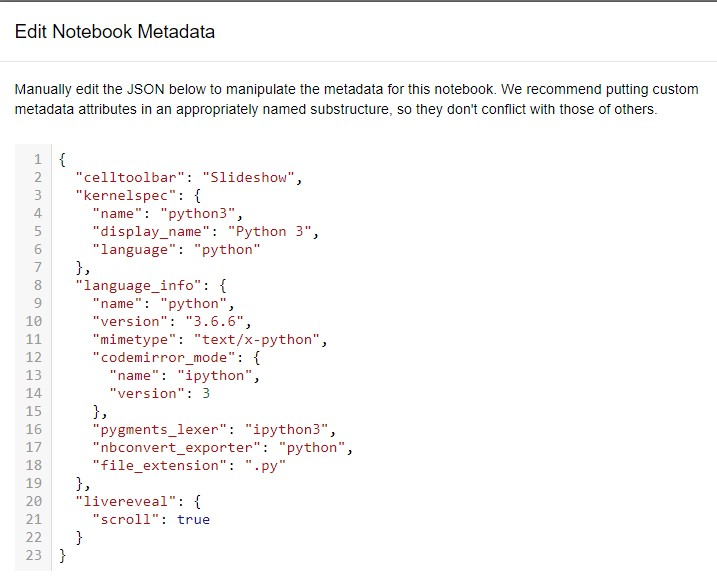